**WAREHOUSE-BASED AUTOMATED DETECTION AND CLASSIFICATION OF SCREEN DEFECTS IN RETURNED PHONES FOR MOBILE CARRIER NOTIFICATION**

**Importing all the important libraries**

In [1]:
!pip install tensorflow

In [2]:
!pip install Augmentor

In [3]:
import pathlib
import os, shutil
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3, Xception, VGG16, VGG19, ResNet50, MobileNetV2, ResNet50V2, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import Augmentor

**Data Visualization**

In [4]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Mobile_Screens')

Mounted at /content/drive


In [5]:
subdirs = [d for d in os.listdir('.') if os.path.isdir(d)]
print(subdirs)

['good', 'oil', 'scratch', 'stain']


Class: good, Number of Images: 420


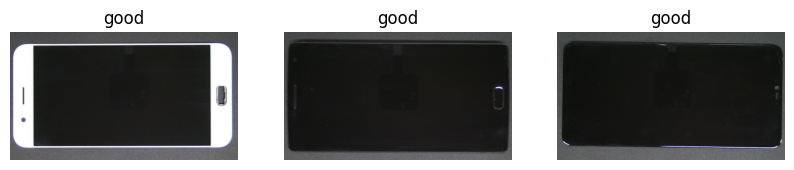

Class: oil, Number of Images: 400


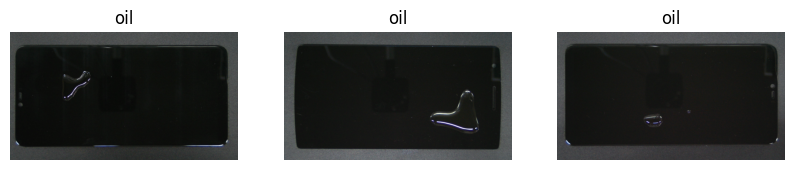

Class: scratch, Number of Images: 400


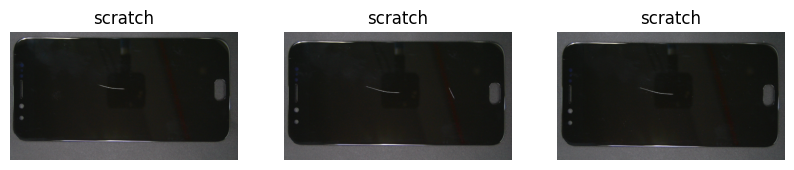

Class: stain, Number of Images: 400


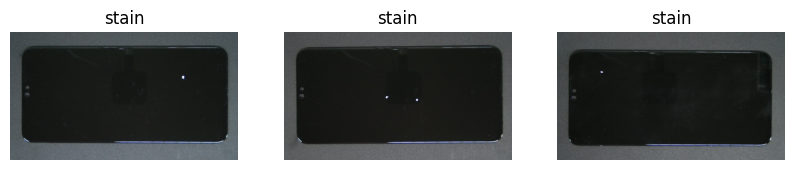

In [6]:
# Specify the root directory containing the class directories
root_dir = '/content/drive/MyDrive/Mobile_Screens'  # Replace with your path

# Iterate through each class directory
for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    if os.path.isdir(class_path):

        # Count images in the class
        num_images = len(os.listdir(class_path))

        # Display class name and image count
        print(f"Class: {class_dir}, Number of Images: {num_images}")

        # Display a few sample images
        plt.figure(figsize=(10, 4))  # Adjust figure size as needed
        for i in range(min(3, num_images)):  # Display up to 3 images
            sample_img = Image.open(os.path.join(class_path, os.listdir(class_path)[i]))
            plt.subplot(1, 3, i+1)
            plt.imshow(sample_img)
            plt.axis('off')
            plt.title(class_dir)
        plt.show()

**Model Building**

**Augmentation**

In [ ]:
input_folder = '/content/drive/MyDrive/Mobile_Screens/good/'
output_folder = '/content/drive/MyDrive/Mobile_Screens/good/'

# Create an Augmentor pipeline
pipeline = Augmentor.Pipeline(input_folder, output_folder)

# Resize images to 400%
pipeline.resize(probability=1.0, width=400, height=400)

# Number of augmented samples to generate for each original image
num_samples = 400

# Execute the augmentation
pipeline.sample(num_samples)

Initialised with 20 image(s) found.
Output directory set to /content/drive/MyDrive/Mobile_Screens/good/.

Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x7CC84C623EE0>: 100%|██████████| 400/400 [00:58<00:00,  6.89 Samples/s]


**InceptionV3 Model**

In [46]:
class InceptionModel:
    def __init__(self, base_model, input_size, num_classes, batch_size=32, num_epochs=10):
        self.base_model = base_model
        self.input_size = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def build_model(self):
        x = self.base_model.output
        x= Flatten()(x)
        x = Dense(128, activation='relu')(x)
        # x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=self.base_model.input, outputs=predictions)
        return model

    def get_preprocess_function(self):
        # Check if the base model has a preprocess_input method
        if hasattr(self.base_model, 'preprocess_input'):
            return self.base_model.preprocess_input
        elif self.base_model.name=='inception_v3':
          return tf.keras.applications.inception_v3.preprocess_input
        elif self.base_model.name=='MobilenetV3small':
          return tf.keras.applications.mobilenet_v3.preprocess_input
        elif self.base_model.name=='resnet50v2':
          return tf.keras.applications.resnet_v2.preprocess_input
        elif self.base_model.name=='densenet201':
          return tf.keras.applications.densenet.preprocess_input
        elif self.base_model.name=='vgg16':
          return tf.keras.applications.vgg16.preprocess_input
        elif self.base_model.name=='vgg19':
          return tf.keras.applications.vgg19.preprocess_input
        else:
            # Define a generic preprocess function if not available
            return lambda x: x / 255.0

    def evaluate_model(self, test_generator, model):
        # Evaluate the model on the test set
        eval_result = model.evaluate(test_generator)
        print("Test Loss:", eval_result[0])
        print("Test Accuracy:", eval_result[1])

    def plot_training_history(self, history, modelname, test_generator, model):
        # Plot training history (loss and accuracy)
        plt.figure(figsize=(8, 3))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{modelname} Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{modelname} Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

        true_labels = test_generator.classes
        if len(true_labels.shape) > 1:
          true_labels = np.argmax(true_labels, axis=1)
        y_pred_prob = model.predict(test_generator)
        predicted_labels = np.argmax(y_pred_prob, axis=1)

        # Calculate confusion matrix, recall, sensitivity, and F1-score
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)


         # Plot confusion matrix using seaborn
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['good', 'oil', 'scratch', 'stain'], yticklabels=['good', 'oil', 'scratch', 'stain'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

         # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels, target_names=['good', 'oil', 'scratch', 'stain']))


    def train_and_evaluate(self, data_dir, modelname):
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,  # 20% of the data will be used for validation
            preprocessing_function=self.get_preprocess_function(),
            rotation_range=20,  # Data augmentation: Random rotation
            width_shift_range=0.2,  # Data augmentation: Random width shift
            height_shift_range=0.2,  # Data augmentation: Random height shift
            horizontal_flip=True,  # Data augmentation: Horizontal flip
            fill_mode='nearest'
        )

        # Flow training images in batches using train_data_dir
        train_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Flow validation images in batches using validation_data_dir
        validation_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        # Assuming you have the train_generator with class indices
        class_indices = train_generator.classes
        class_labels = np.unique(class_indices)

        model = self.build_model()
        for layer in model.layers[:-10]:  # Unfreeze the last 4 layers for fine-tuning
          layer.trainable = False
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

         # Adding callbacks for dynamic learning rate and early stopping
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000001)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

        # Specify the path to save the model with the highest validation accuracy
        checkpoint_path = f"/drive/MyDrive/{modelname}_best_model.h5"
        model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')


        history = model.fit(
            train_generator,
            epochs=self.num_epochs,
            steps_per_epoch = len(train_generator),
            validation_data=validation_generator,
            callbacks=[reduce_lr,early_stopping,model_checkpoint]

        )
        # Load the best model based on validation accuracy
        best_model = load_model(checkpoint_path)

         # Evaluate the model on the test set
        self.evaluate_model(validation_generator, best_model)

        # Plot training history
        self.plot_training_history(history, modelname, validation_generator, best_model)


# Example usage:
# Specify parameters
input_size = (299, 299)
num_classes = 4  # Adjust based on your number of classes
batch_size = 32
num_epochs = 20


87910968/87910968 [==============================] - 3s 0us/step
Found 1296 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 4.1311 - accuracy: 0.3333

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 127s 3s/step - loss: 4.1311 - accuracy: 0.3333 - val_loss: 1.3560 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
41/41 [==============================] - 116s 3s/step - loss: 1.3045 - accuracy: 0.4637 - val_loss: 1.4435 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 3/20
41/41 [==============================] - 117s 3s/step - loss: 1.1883 - accuracy: 0.5185 - val_loss: 1.1643 - val_accuracy: 0.5648 - lr: 0.0010
Epoch 4/20
41/41 [==============================] - 114s 3s/step - loss: 1.0917 - accuracy: 0.5710 - val_loss: 1.4459 - val_accuracy: 0.3920 - lr: 0.0010
Epoch 5/20
41/41 [==============================] - 114s 3s/step - loss: 1.0248 - accuracy: 0.5972 - val_loss: 1.5974 - val_accuracy: 0.4506 - lr: 0.0010
Epoch 6/20
41/41 [==============================] - 115s 3s/step - loss: 1.0664 - accuracy: 0.5864 - val_loss: 1.3675 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 7/20
41/41 [==============================] - 115s 3s/step - loss: 0.8247 - accur

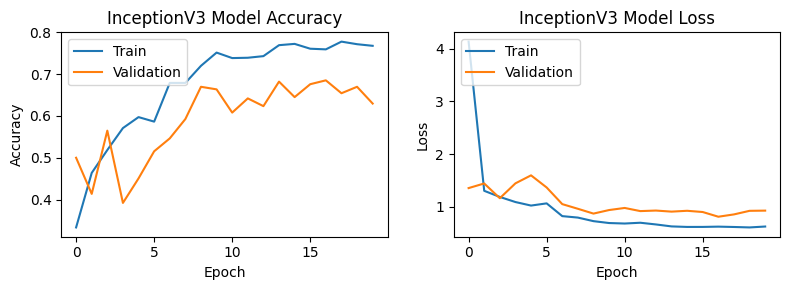

11/11 [==============================] - 25s 2s/step


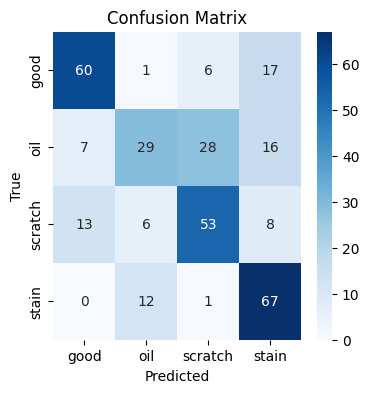


Classification Report:
              precision    recall  f1-score   support

        good       0.75      0.71      0.73        84
         oil       0.60      0.36      0.45        80
     scratch       0.60      0.66      0.63        80
       stain       0.62      0.84      0.71        80

    accuracy                           0.65       324
   macro avg       0.64      0.64      0.63       324
weighted avg       0.65      0.65      0.63       324



In [47]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
trainer = InceptionModel(base_model, (299,299), num_classes, batch_size, num_epochs)
trainer.train_and_evaluate(data_dir='/content/drive/MyDrive/Mobile_Screens',  modelname='InceptionV3')

In [13]:
class DensenetModel:
    def __init__(self, base_model, input_size, num_classes, batch_size=32, num_epochs=10):
        self.base_model = base_model
        self.input_size = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def build_model(self):
        x = self.base_model.output
        x= Flatten()(x)
        x = Dense(128, activation='relu')(x)
        # x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=self.base_model.input, outputs=predictions)
        return model

    def get_preprocess_function(self):
        # Check if the base model has a preprocess_input method
        if hasattr(self.base_model, 'preprocess_input'):
            return self.base_model.preprocess_input
        elif self.base_model.name=='inception_v3':
          return tf.keras.applications.inception_v3.preprocess_input
        elif self.base_model.name=='MobilenetV3small':
          return tf.keras.applications.mobilenet_v3.preprocess_input
        elif self.base_model.name=='resnet50v2':
          return tf.keras.applications.resnet_v2.preprocess_input
        elif self.base_model.name=='densenet201':
          return tf.keras.applications.densenet.preprocess_input
        elif self.base_model.name=='vgg16':
          return tf.keras.applications.vgg16.preprocess_input
        elif self.base_model.name=='vgg19':
          return tf.keras.applications.vgg19.preprocess_input
        else:
            # Define a generic preprocess function if not available
            return lambda x: x / 255.0

    def evaluate_model(self, test_generator, model):
        # Evaluate the model on the test set
        eval_result = model.evaluate(test_generator)
        print("Test Loss:", eval_result[0])
        print("Test Accuracy:", eval_result[1])

    def plot_training_history(self, history, modelname, test_generator, model):
        # Plot training history (loss and accuracy)
        plt.figure(figsize=(8, 3))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{modelname} Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{modelname} Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

        true_labels = test_generator.classes
        if len(true_labels.shape) > 1:
          true_labels = np.argmax(true_labels, axis=1)
        y_pred_prob = model.predict(test_generator)
        predicted_labels = np.argmax(y_pred_prob, axis=1)

        # Calculate confusion matrix, recall, sensitivity, and F1-score
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)


         # Plot confusion matrix using seaborn
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['good', 'oil', 'scratch', 'stain'], yticklabels=['good', 'oil', 'scratch', 'stain'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

         # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels, target_names=['good', 'oil', 'scratch', 'stain']))


    def train_and_evaluate(self, data_dir, modelname):
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,  # 20% of the data will be used for validation
            preprocessing_function=self.get_preprocess_function(),
            rotation_range=20,  # Data augmentation: Random rotation
            width_shift_range=0.2,  # Data augmentation: Random width shift
            height_shift_range=0.2,  # Data augmentation: Random height shift
            horizontal_flip=True,  # Data augmentation: Horizontal flip
            fill_mode='nearest'
        )

        # Flow training images in batches using train_data_dir
        train_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Flow validation images in batches using validation_data_dir
        validation_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        # Assuming you have the train_generator with class indices
        class_indices = train_generator.classes
        class_labels = np.unique(class_indices)

        model = self.build_model()
        for layer in model.layers[:-6]:  # Unfreeze the last 4 layers for fine-tuning
          layer.trainable = False
        model.compile(optimizer=Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

         # Adding callbacks for dynamic learning rate and early stopping
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000001)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

        # Specify the path to save the model with the highest validation accuracy
        checkpoint_path = f"/drive/MyDrive/{modelname}_best_model.h5"
        model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')


        history = model.fit(
            train_generator,
            epochs=self.num_epochs,
            steps_per_epoch = len(train_generator),
            validation_data=validation_generator,
            callbacks=[reduce_lr,early_stopping,model_checkpoint]

        )
        # Load the best model based on validation accuracy
        best_model = load_model(checkpoint_path)

         # Evaluate the model on the test set
        self.evaluate_model(validation_generator, best_model)

        # Plot training history
        self.plot_training_history(history, modelname, validation_generator, best_model)


# Example usage:
# Specify parameters
input_size = (299, 299)
num_classes = 4  # Adjust based on your number of classes
batch_size = 32
num_epochs = 20


Found 1296 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.3140

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 109s 2s/step - loss: 1.4280 - accuracy: 0.3140 - val_loss: 1.3813 - val_accuracy: 0.3549 - lr: 1.0000e-05
Epoch 2/20
41/41 [==============================] - 93s 2s/step - loss: 1.3051 - accuracy: 0.3665 - val_loss: 1.3556 - val_accuracy: 0.2994 - lr: 1.0000e-05
Epoch 3/20
41/41 [==============================] - 95s 2s/step - loss: 1.2702 - accuracy: 0.4159 - val_loss: 1.3051 - val_accuracy: 0.4259 - lr: 1.0000e-05
Epoch 4/20
41/41 [==============================] - 94s 2s/step - loss: 1.2348 - accuracy: 0.4136 - val_loss: 1.3186 - val_accuracy: 0.3981 - lr: 1.0000e-05
Epoch 5/20
41/41 [==============================] - 93s 2s/step - loss: 1.1852 - accuracy: 0.4861 - val_loss: 1.3490 - val_accuracy: 0.4198 - lr: 1.0000e-05
Epoch 6/20
41/41 [==============================] - 95s 2s/step - loss: 1.1513 - accuracy: 0.4977 - val_loss: 1.3058 - val_accuracy: 0.4722 - lr: 1.0000e-05
Epoch 7/20
41/41 [==============================] - 94s 2s/step - lo

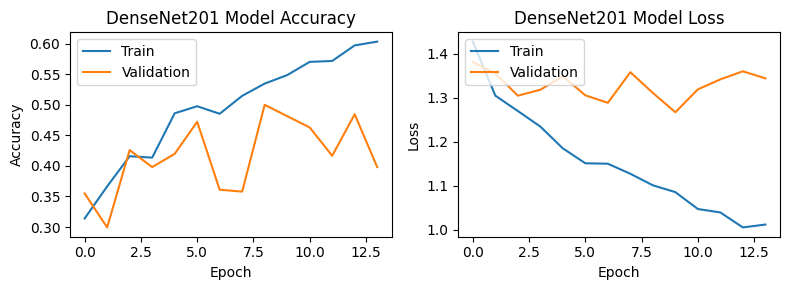

11/11 [==============================] - 22s 2s/step


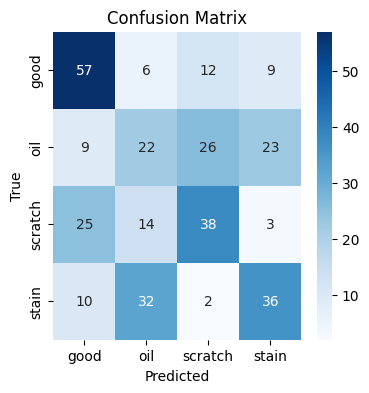


Classification Report:
              precision    recall  f1-score   support

        good       0.56      0.68      0.62        84
         oil       0.30      0.28      0.29        80
     scratch       0.49      0.47      0.48        80
       stain       0.51      0.45      0.48        80

    accuracy                           0.47       324
   macro avg       0.46      0.47      0.46       324
weighted avg       0.47      0.47      0.47       324



In [14]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
trainer = DensenetModel(base_model, (224,224), num_classes, batch_size, num_epochs)
trainer.train_and_evaluate(data_dir='/content/drive/MyDrive/Mobile_Screens', modelname='DenseNet201')

In [44]:
class XceptionModel:
    def __init__(self, base_model, input_size, num_classes, batch_size=32, num_epochs=10):
        self.base_model = base_model
        self.input_size = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def build_model(self):
        x = self.base_model.output
        x= Flatten()(x)
        x = Dense(64, kernel_regularizer=regularizers.l2(0.01),activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=self.base_model.input, outputs=predictions)
        return model

    def get_preprocess_function(self):
        # Check if the base model has a preprocess_input method
        if hasattr(self.base_model, 'preprocess_input'):
            return self.base_model.preprocess_input
        elif self.base_model.name=='inception_v3':
          return tf.keras.applications.inception_v3.preprocess_input
        elif self.base_model.name=='MobilenetV3small':
          return tf.keras.applications.mobilenet_v3.preprocess_input
        elif self.base_model.name=='resnet50v2':
          return tf.keras.applications.resnet_v2.preprocess_input
        elif self.base_model.name=='densenet201':
          return tf.keras.applications.densenet.preprocess_input
        elif self.base_model.name=='vgg16':
          return tf.keras.applications.vgg16.preprocess_input
        elif self.base_model.name=='vgg19':
          return tf.keras.applications.vgg19.preprocess_input
        else:
            # Define a generic preprocess function if not available
            return lambda x: x / 255.0

    def evaluate_model(self, test_generator, model):
        # Evaluate the model on the test set
        eval_result = model.evaluate(test_generator)
        print("Test Loss:", eval_result[0])
        print("Test Accuracy:", eval_result[1])

    def plot_training_history(self, history, modelname, test_generator, model):
        # Plot training history (loss and accuracy)
        plt.figure(figsize=(8, 3))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{modelname} Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{modelname} Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

        true_labels = test_generator.classes
        if len(true_labels.shape) > 1:
          true_labels = np.argmax(true_labels, axis=1)
        y_pred_prob = model.predict(test_generator)
        predicted_labels = np.argmax(y_pred_prob, axis=1)

        # Calculate confusion matrix, recall, sensitivity, and F1-score
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)


         # Plot confusion matrix using seaborn
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['good', 'oil', 'scratch', 'stain'], yticklabels=['good', 'oil', 'scratch', 'stain'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

         # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels, target_names=['good', 'oil', 'scratch', 'stain']))


    def train_and_evaluate(self, data_dir, modelname):
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,  # 20% of the data will be used for validation
            preprocessing_function=tf.keras.applications.xception.preprocess_input,
            rotation_range=20,  # Data augmentation: Random rotation
            width_shift_range=0.2,  # Data augmentation: Random width shift
            height_shift_range=0.2,  # Data augmentation: Random height shift
            horizontal_flip=True,  # Data augmentation: Horizontal flip
            fill_mode='nearest'
        )

        # Flow training images in batches using train_data_dir
        train_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Flow validation images in batches using validation_data_dir
        validation_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        # Assuming you have the train_generator with class indices
        class_indices = train_generator.classes
        class_labels = np.unique(class_indices)

        model = self.build_model()
        # for layer in model.layers[:-2]:
        #   layer.trainable = False

        model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

         # Adding callbacks for dynamic learning rate and early stopping
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

        # Specify the path to save the model with the highest validation accuracy
        checkpoint_path = f"/drive/MyDrive/{modelname}_best_model.h5"
        model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')


        history = model.fit(
            train_generator,
            epochs=self.num_epochs,
            steps_per_epoch = len(train_generator),
            validation_data=validation_generator,
            callbacks=[reduce_lr,early_stopping,model_checkpoint]

        )
        # Load the best model based on validation accuracy
        best_model = load_model(checkpoint_path)

         # Evaluate the model on the test set
        self.evaluate_model(validation_generator, best_model)

        # Plot training history
        self.plot_training_history(history, modelname, validation_generator, best_model)


# Example usage:
# Specify parameters
input_size = (299, 299)
num_classes = 4  # Adjust based on your number of classes
batch_size = 16
num_epochs = 20


Found 1296 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 2.3393 - accuracy: 0.5185

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 139s 1s/step - loss: 2.3393 - accuracy: 0.5185 - val_loss: 2.6398 - val_accuracy: 0.2654 - lr: 1.0000e-05
Epoch 2/20
81/81 [==============================] - 115s 1s/step - loss: 1.6978 - accuracy: 0.8318 - val_loss: 2.5957 - val_accuracy: 0.2531 - lr: 1.0000e-05
Epoch 3/20
81/81 [==============================] - 116s 1s/step - loss: 1.4434 - accuracy: 0.9198 - val_loss: 2.5147 - val_accuracy: 0.4167 - lr: 1.0000e-05
Epoch 4/20
81/81 [==============================] - 117s 1s/step - loss: 1.3283 - accuracy: 0.9429 - val_loss: 2.2965 - val_accuracy: 0.5340 - lr: 1.0000e-05
Epoch 5/20
81/81 [==============================] - 117s 1s/step - loss: 1.2750 - accuracy: 0.9552 - val_loss: 1.8718 - val_accuracy: 0.7068 - lr: 1.0000e-05
Epoch 6/20
81/81 [==============================] - 122s 1s/step - loss: 1.2184 - accuracy: 0.9653 - val_loss: 1.5134 - val_accuracy: 0.8302 - lr: 1.0000e-05
Epoch 7/20
81/81 [==============================] - 122s 1s/ste

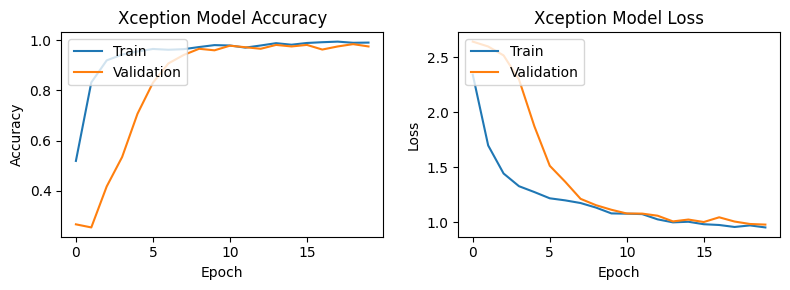

21/21 [==============================] - 24s 1s/step


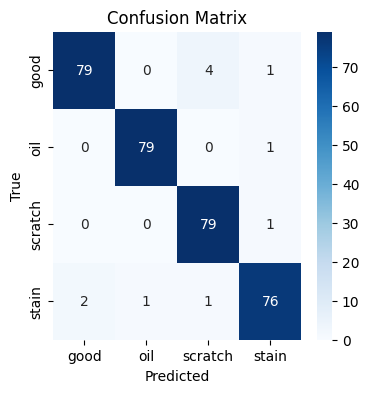


Classification Report:
              precision    recall  f1-score   support

        good       0.98      0.94      0.96        84
         oil       0.99      0.99      0.99        80
     scratch       0.94      0.99      0.96        80
       stain       0.96      0.95      0.96        80

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



In [45]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
trainer = XceptionModel(base_model, (299,299), num_classes, batch_size,num_epochs)
trainer.train_and_evaluate(data_dir='/content/drive/MyDrive/Mobile_Screens', modelname='Xception')

In [22]:
base_model.name

'xception'

In [15]:
class PretrainedModelTrainer:
    def __init__(self, base_model, input_size, num_classes, batch_size=32, num_epochs=10):
        self.base_model = base_model
        self.input_size = input_size
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def build_model(self):
        x = self.base_model.output
        x= Flatten()(x)
        x = Dense(128, activation='relu')(x)
        # x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=self.base_model.input, outputs=predictions)
        return model

    def get_preprocess_function(self):
        # Check if the base model has a preprocess_input method
        if hasattr(self.base_model, 'preprocess_input'):
            return self.base_model.preprocess_input
        elif self.base_model.name=='inception_v3':
          return tf.keras.applications.inception_v3.preprocess_input
        elif self.base_model.name=='MobilenetV3small':
          return tf.keras.applications.mobilenet_v3.preprocess_input
        elif self.base_model.name=='resnet50v2':
          return tf.keras.applications.resnet_v2.preprocess_input
        elif self.base_model.name=='densenet201':
          return tf.keras.applications.densenet.preprocess_input
        elif self.base_model.name=='vgg16':
          return tf.keras.applications.vgg16.preprocess_input
        elif self.base_model.name=='vgg19':
          return tf.keras.applications.vgg19.preprocess_input
        else:
            # Define a generic preprocess function if not available
            return lambda x: x / 255.0

    def evaluate_model(self, test_generator, model):
        # Evaluate the model on the test set
        eval_result = model.evaluate(test_generator)
        print("Test Loss:", eval_result[0])
        print("Test Accuracy:", eval_result[1])

    def plot_training_history(self, history, modelname, test_generator, model):
        # Plot training history (loss and accuracy)
        plt.figure(figsize=(8, 3))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{modelname} Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{modelname} Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

        true_labels = test_generator.classes
        if len(true_labels.shape) > 1:
          true_labels = np.argmax(true_labels, axis=1)
        y_pred_prob = model.predict(test_generator)
        predicted_labels = np.argmax(y_pred_prob, axis=1)

        # Calculate confusion matrix, recall, sensitivity, and F1-score
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)


         # Plot confusion matrix using seaborn
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['good', 'oil', 'scratch', 'stain'], yticklabels=['good', 'oil', 'scratch', 'stain'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

         # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels, target_names=['good', 'oil', 'scratch', 'stain']))


    def train_and_evaluate(self, data_dir, modelname):
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,  # 20% of the data will be used for validation
            preprocessing_function=self.get_preprocess_function(),
            rotation_range=20,  # Data augmentation: Random rotation
            width_shift_range=0.2,  # Data augmentation: Random width shift
            height_shift_range=0.2,  # Data augmentation: Random height shift
            horizontal_flip=True,  # Data augmentation: Horizontal flip
            fill_mode='nearest'
        )

        # Flow training images in batches using train_data_dir
        train_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )

        # Flow validation images in batches using validation_data_dir
        validation_generator = datagen.flow_from_directory(
            data_dir,
            target_size=self.input_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        # Assuming you have the train_generator with class indices
        class_indices = train_generator.classes
        class_labels = np.unique(class_indices)

        model = self.build_model()

        model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

         # Adding callbacks for dynamic learning rate and early stopping
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

        # Specify the path to save the model with the highest validation accuracy
        checkpoint_path = f"/drive/MyDrive/{modelname}_best_model.h5"
        model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')


        history = model.fit(
            train_generator,
            epochs=self.num_epochs,
            steps_per_epoch = len(train_generator),
            validation_data=validation_generator,
            callbacks=[reduce_lr,early_stopping,model_checkpoint]

        )
        # Load the best model based on validation accuracy
        best_model = load_model(checkpoint_path)

         # Evaluate the model on the test set
        self.evaluate_model(validation_generator, best_model)

        # Plot training history
        self.plot_training_history(history, modelname, validation_generator, best_model)


# Example usage:
# Specify parameters
input_size = (299, 299)
num_classes = 4  # Adjust based on your number of classes
batch_size = 64
num_epochs = 20


58889256/58889256 [==============================] - 0s 0us/step
Found 1296 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4071 - accuracy: 0.3356

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 129s 4s/step - loss: 1.4071 - accuracy: 0.3356 - val_loss: 1.3291 - val_accuracy: 0.4043 - lr: 1.0000e-05
Epoch 2/20
21/21 [==============================] - 95s 5s/step - loss: 1.1378 - accuracy: 0.5934 - val_loss: 1.0287 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 3/20
21/21 [==============================] - 94s 4s/step - loss: 0.6132 - accuracy: 0.8233 - val_loss: 0.4469 - val_accuracy: 0.8395 - lr: 1.0000e-05
Epoch 4/20
21/21 [==============================] - 96s 5s/step - loss: 0.2263 - accuracy: 0.9275 - val_loss: 0.2848 - val_accuracy: 0.9136 - lr: 1.0000e-05
Epoch 5/20
21/21 [==============================] - 94s 4s/step - loss: 0.1741 - accuracy: 0.9475 - val_loss: 0.2908 - val_accuracy: 0.9105 - lr: 1.0000e-05
Epoch 6/20
21/21 [==============================] - 94s 4s/step - loss: 0.1214 - accuracy: 0.9676 - val_loss: 0.2433 - val_accuracy: 0.9198 - lr: 5.0000e-06
Epoch 7/20
21/21 [==============================] - 95s 4s/step - lo

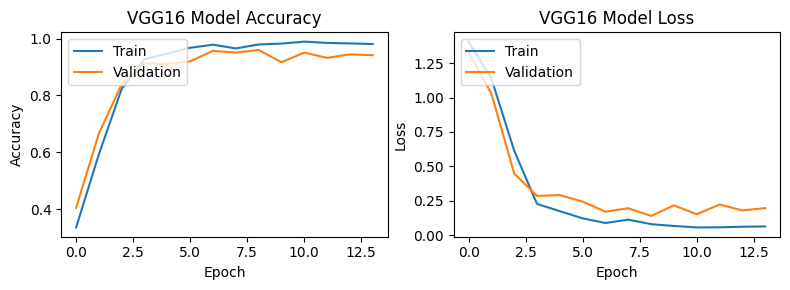

6/6 [==============================] - 19s 3s/step


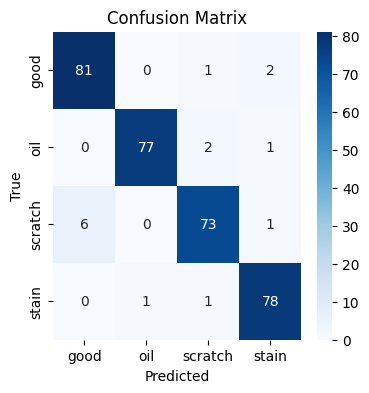


Classification Report:
              precision    recall  f1-score   support

        good       0.93      0.96      0.95        84
         oil       0.99      0.96      0.97        80
     scratch       0.95      0.91      0.93        80
       stain       0.95      0.97      0.96        80

    accuracy                           0.95       324
   macro avg       0.95      0.95      0.95       324
weighted avg       0.95      0.95      0.95       324



In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
trainer = PretrainedModelTrainer(base_model, (224,224), num_classes, batch_size,num_epochs)
trainer.train_and_evaluate(data_dir='/content/drive/MyDrive/Mobile_Screens', modelname='VGG16')

80134624/80134624 [==============================] - 0s 0us/step
Found 1296 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.3132 - accuracy: 0.4043

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 100s 5s/step - loss: 1.3132 - accuracy: 0.4043 - val_loss: 1.2497 - val_accuracy: 0.4815 - lr: 1.0000e-05
Epoch 2/20
21/21 [==============================] - 95s 5s/step - loss: 0.9310 - accuracy: 0.6991 - val_loss: 0.7941 - val_accuracy: 0.6420 - lr: 1.0000e-05
Epoch 3/20
21/21 [==============================] - 96s 5s/step - loss: 0.4237 - accuracy: 0.8681 - val_loss: 0.3425 - val_accuracy: 0.8765 - lr: 1.0000e-05
Epoch 4/20
21/21 [==============================] - 95s 5s/step - loss: 0.2378 - accuracy: 0.9267 - val_loss: 0.2299 - val_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 5/20
21/21 [==============================] - 95s 4s/step - loss: 0.1636 - accuracy: 0.9545 - val_loss: 0.1644 - val_accuracy: 0.9444 - lr: 1.0000e-05
Epoch 6/20
21/21 [==============================] - 95s 5s/step - loss: 0.1173 - accuracy: 0.9653 - val_loss: 0.1890 - val_accuracy: 0.9383 - lr: 1.0000e-05
Epoch 7/20
21/21 [==============================] - 95s 4s/step - lo

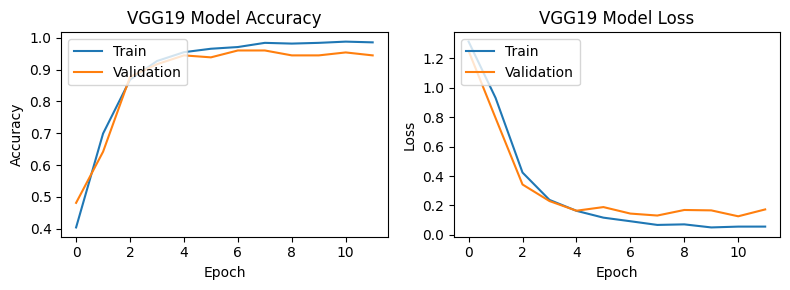

6/6 [==============================] - 19s 3s/step


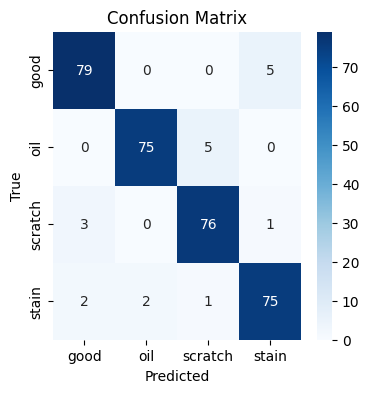


Classification Report:
              precision    recall  f1-score   support

        good       0.94      0.94      0.94        84
         oil       0.97      0.94      0.96        80
     scratch       0.93      0.95      0.94        80
       stain       0.93      0.94      0.93        80

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.94      0.94      0.94       324



In [17]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
trainer = PretrainedModelTrainer(base_model, (224,224), num_classes, batch_size, num_epochs)
trainer.train_and_evaluate(data_dir='/content/drive/MyDrive/Mobile_Screens', modelname='VGG19')
